In [1]:
# Import statements

import hipopy.hipopy as hipopy # <--- Package for reading in the hipo files
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import ROOT
import timeit
import statistics

# Set LaTeX font for Matplotlib
rc('text', usetex=True)

# Set default plot font size
plt.rcParams['font.size'] = 16


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-4i8fabwm because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Welcome to JupyROOT 6.22/06


In [2]:
# opening up some .hipo files

filename0 = "/volatile/clas12/users/mfmce/mc_jobs_rga_vtx_3_23_23/skim_50nA_OB_job_3313_0.hipo"
filename1 = "/volatile/clas12/users/mfmce/mc_jobs_rga_vtx_3_23_23/skim_50nA_OB_job_3313_1.hipo"
filename2 = "/volatile/clas12/users/mfmce/mc_jobs_rga_vtx_3_23_23/skim_50nA_OB_job_3313_2.hipo"
filename3 = "/volatile/clas12/users/mfmce/mc_jobs_rga_vtx_3_23_23/skim_50nA_OB_job_3313_3.hipo"
filename4 = "/volatile/clas12/users/mfmce/mc_jobs_rga_vtx_3_23_23/skim_50nA_OB_job_3313_4.hipo"

hipo_file0 = hipopy.open(filename0,mode='r')
hipo_file1 = hipopy.open(filename1,mode='r')
hipo_file2 = hipopy.open(filename2,mode='r')
hipo_file3 = hipopy.open(filename3,mode='r')
hipo_file4 = hipopy.open(filename4,mode='r')

hipo_array = [hipo_file0, hipo_file1, hipo_file2, hipo_file3, hipo_file4]

# Showing the data types inside each bank

print("REC::Particle data","\n"+100*"=")
display(hipo_file1.getNamesAndTypes('REC::Particle'))
print(100*"=","\nREC::Traj data","\n"+100*"=")
display(hipo_file1.getNamesAndTypes('REC::Traj'))
print("MC::Lund data","\n"+100*"=")
display(hipo_file1.getNamesAndTypes('MC::Lund'))

REC::Particle data 


{'pid': 'I',
 'px': 'F',
 'py': 'F',
 'pz': 'F',
 'vx': 'F',
 'vy': 'F',
 'vz': 'F',
 'vt': 'F',
 'charge': 'B',
 'beta': 'F',
 'chi2pid': 'F',
 'status': 'S'}

REC::Traj data 


{'pindex': 'S',
 'index': 'S',
 'detector': 'B',
 'layer': 'B',
 'x': 'F',
 'y': 'F',
 'z': 'F',
 'cx': 'F',
 'cy': 'F',
 'cz': 'F',
 'path': 'F'}

MC::Lund data 


{'index': 'B',
 'lifetime': 'F',
 'type': 'B',
 'pid': 'I',
 'parent': 'B',
 'daughter': 'B',
 'px': 'F',
 'py': 'F',
 'pz': 'F',
 'energy': 'F',
 'mass': 'F',
 'vx': 'F',
 'vy': 'F',
 'vz': 'F'}

compression type = 0 data length = 24682
compression type = 0 data length = 24682
compression type = 0 data length = 24682
compression type = 0 data length = 24682
compression type = 0 data length = 24682


In [3]:
# defining function to find xF
# q is the pion, p is the virtual photon
def calculate_xF(q, p, init_target):
    W = (init_target + p).M()
    com = q + init_target
    comBOOST = com.BoostVector()
    qq = q
    pp = p
    qq.Boost(-comBOOST)
    pp.Boost(-comBOOST)
    return 2 * ( qq.Vect().Dot(pp.Vect()) ) / ( qq.Vect().Mag() * W )

# defining functions to get Q2

# for the pion
def cthfunc(Px, Py, Pz):

    Pt = np.sqrt(Px*Px + Py*Py)
    return Pz / np.sqrt(Pz * Pz + Pt * Pt)

# for the electrons
def Q2func(E2, cth):
    E1 = 10.6 # GeV
    return 2 * E1 * E2 * (1.0 - cth)

# in MC::Lund, we want the energy of the second electron, so we need this function:
def find_second_index(lst, value):
    try:
        first_index = lst.index(value)
        return lst.index(value, first_index + 1)
    except ValueError:
        # Handle the case when the value is not found or there is no second occurrence
        return None

# making random colors
import random

def get_random_color():
    # Generate random values for red, green, and blue channels
    r = random.random()
    g = random.random()
    b = random.random()

    # Return the color as a tuple
    return r, g, b

In [4]:
Mpion = 0.139570 # GeV
Mproton = 0.938272 # GeV

In [5]:
p_recon = []
theta_recon = []
phi_recon = []

p_true = []
theta_true = []
phi_true = []

xF = []
q2 = []

# limit on iterations (for each hipo file)
Nevents = 1e5

start_time = timeit.default_timer()

for k,_ in enumerate(hipo_array):
    
    for i,_ in enumerate(hipo_array[k]):
        if (i > Nevents):
            break

        # pulling out data from each event
        detectors_temp = hipo_array[k].getBytes("REC::Traj", "detector")
        p_index_temp = hipo_array[k].getShorts("REC::Traj", "pindex")
        charge_temp = hipo_array[k].getBytes("REC::Particle", "charge")
        
        px_recon = hipo_array[k].getFloats("REC::Particle", "px")
        py_recon = hipo_array[k].getFloats("REC::Particle", "py")
        pz_recon = hipo_array[k].getFloats("REC::Particle", "pz")
        pid_recon = hipo_array[k].getInts("REC::Particle", "pid")
                
        # delete the data of the neutral particles since it'll make counting with pindex possible
        if 0 in charge_temp:
            first_zero_index = charge_temp.index(0)
            del px_recon[first_zero_index:], py_recon[first_zero_index:], pz_recon[first_zero_index:], pid_recon[first_zero_index:], charge_temp[first_zero_index:]
            
        pion_indices_recon = [q for q in range(len(pid_recon)) if pid_recon[q] == -211]
        
        # getting info on the virtual photon so I can do the xF > 0 cut
        pid_Lund = hipo_array[k].getInts("MC::Lund", "pid")
        px_Lund = hipo_array[k].getFloats("MC::Lund", "px")
        py_Lund = hipo_array[k].getFloats("MC::Lund", "py")
        pz_Lund = hipo_array[k].getFloats("MC::Lund", "pz")
        masses = hipo_array[k].getFloats("MC::Lund", "mass")
        energies = hipo_array[k].getFloats("MC::Lund", "energy")
        
        virtual_photon_index = pid_Lund.index(22)
        virtual_photon = ROOT.TLorentzVector()
        virtual_photon.SetXYZM(px_Lund[virtual_photon_index], py_Lund[virtual_photon_index], pz_Lund[virtual_photon_index], masses[virtual_photon_index])
        
        # initial target: proton at rest
        proton_target = ROOT.TLorentzVector()
        proton_target.SetXYZM(0, 0, 0, Mproton)
        
        # Q2 cut
        scattered_electron_index = find_second_index(pid_Lund, 11)
        cth = cthfunc(px_Lund[scattered_electron_index], py_Lund[scattered_electron_index], pz_Lund[scattered_electron_index])

        q2_temp = Q2func(energies[scattered_electron_index], cth)
        q2.append(q2_temp)
        if q2_temp < 1:
            continue
        
        # looping through pions
        for j,_ in enumerate(pion_indices_recon):
            
            pion_location = pion_indices_recon[j]
            pion_vector_recon = ROOT.TLorentzVector()
            pion_vector_recon.SetXYZM(px_recon[pion_location], py_recon[pion_location], pz_recon[pion_location], Mpion)
            
            # xF cut
            xF_temp = calculate_xF(pion_vector_recon, virtual_photon, proton_target)
            xF.append(xF_temp)
            if xF_temp <= 0:
                continue
            
            p_recon_temp = pion_vector_recon.P()
            if (p_recon_temp < 2): # let's not deal with the pions with stupid high momentum
                
                p_recon.append(p_recon_temp) # append total momentum
                theta_recon.append(pion_vector_recon.Theta() *180/np.pi) # append calculated azimuthal angle in degrees
                phi_recon.append(pion_vector_recon.Phi() *180/np.pi) # append calculated polar angle in degrees

        
        # true data now
        
        px_true = hipo_array[k].getFloats("MC::Lund", "px")
        py_true = hipo_array[k].getFloats("MC::Lund", "py")
        pz_true = hipo_array[k].getFloats("MC::Lund", "pz")
        pid_true = hipo_array[k].getInts("MC::Lund", "pid")
        
        pion_indices_true = [q for q in range(len(pid_true)) if pid_true[q] == -211]
        
        # looping through pions
        for j,_ in enumerate(pion_indices_true):
            
            pion_location = pion_indices_true[j]
            pion_vector_true = ROOT.TLorentzVector()
            pion_vector_true.SetXYZM(px_true[pion_location], py_true[pion_location], pz_true[pion_location], Mpion)
            
            # xF cut
            xF_temp = calculate_xF(pion_vector_true, virtual_photon, proton_target)
            xF.append(xF_temp)
            if xF_temp <= 0:
                continue
            
            p_true.append(pion_vector_true.P()) # append total momentum
            theta_true.append(pion_vector_true.Theta() *180/np.pi) # append calculated azimuthal angle in degrees
            phi_true.append(pion_vector_true.Phi() *180/np.pi) # append calculated polar angle in degrees
        
print("time spent computing:", timeit.default_timer() - start_time)

time spent computing: 192.05706351529807


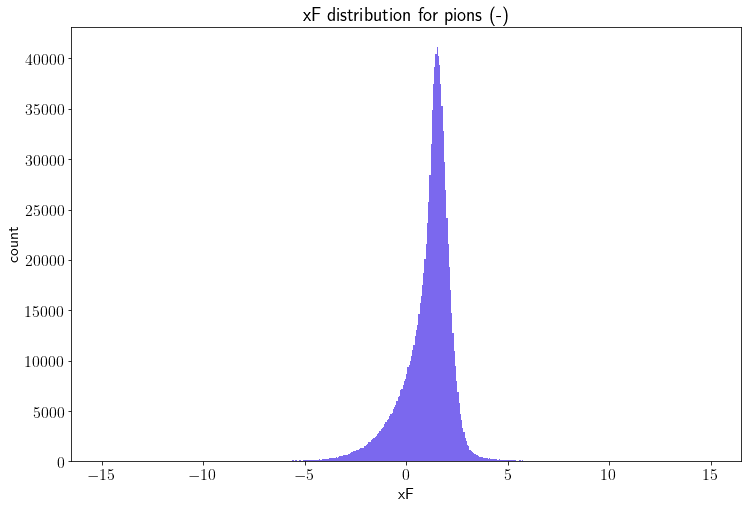

In [6]:
# checking xF distribution to see if it makes sense
xF = np.array(xF)

plt.figure(figsize=(12, 8))
plt.hist(xF[abs(xF) < 15], bins=500, color="mediumslateblue")
plt.xlabel("xF")
plt.ylabel("count")
plt.title("xF distribution for pions (-)")
plt.show()

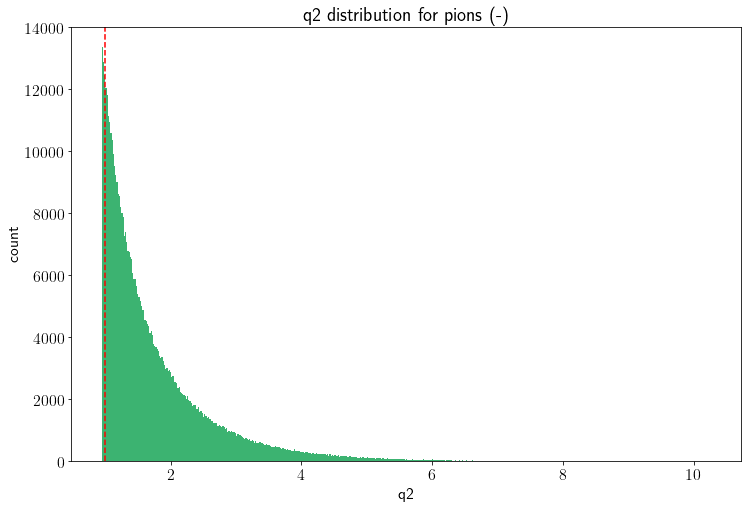

In [7]:
# checking q2 distribution to see if it makes sense

plt.figure(figsize=(12, 8))
plt.hist(q2, bins=500, color="mediumseagreen")
plt.xlabel("q2")
plt.ylabel("count")
plt.title("q2 distribution for pions (-)")
plt.axvline(x=1, color='red', linestyle='--')
plt.show()

In [8]:
print("p vector lengths:", len(p_true), len(p_recon))

p vector lengths: 475401 493575


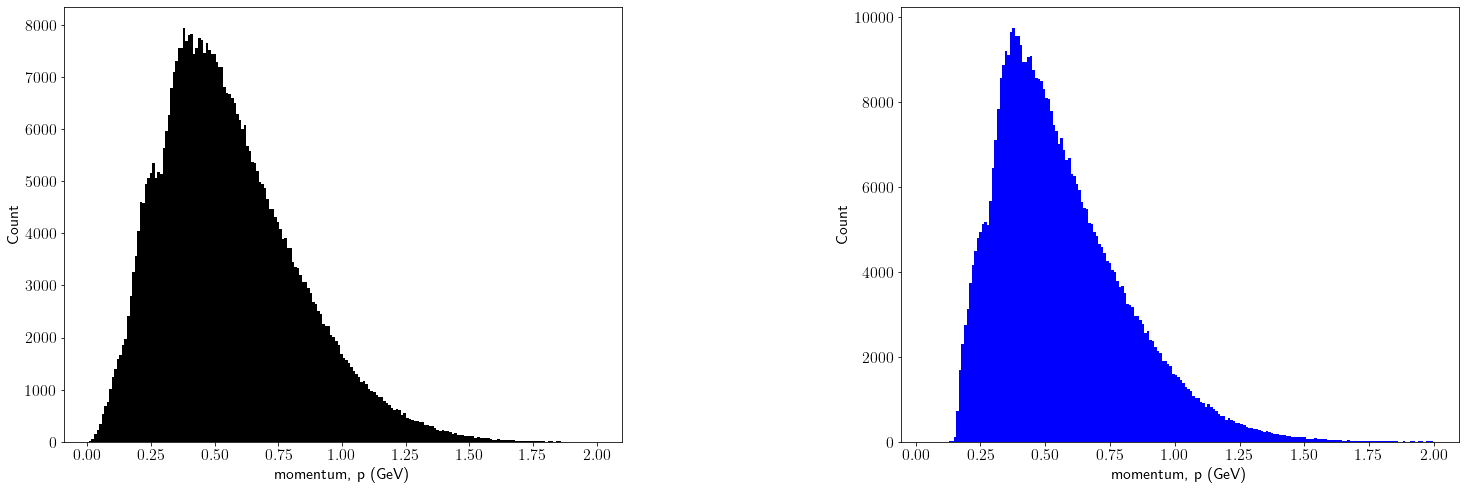

In [9]:
# Create a grid of subplots
fig1, axs1 = plt.subplots(1, 2, figsize=(25, 8))

# Adjust spacing
fig1.subplots_adjust(hspace=0.5)
fig1.subplots_adjust(wspace=0.5)

axs1[0].hist(p_true, bins=200, color="black")
axs1[0].set_xlabel("momentum, p (GeV)")
axs1[0].set_ylabel("Count")

axs1[1].hist(p_recon, bins=200, color="blue")
axs1[1].set_xlabel("momentum, p (GeV)")
axs1[1].set_ylabel("Count")

plt.show()

In [10]:
# split into different sections based on momentum
# look at resolutions for 0-1 GeV, 1-2 GeV, etc.
# 0:0.5:4

In [11]:
num_sublists = 10
max_p = 2

p_true_sublists = [[] for _ in range(num_sublists)]
theta_true_sublists = [[] for _ in range(num_sublists)]
phi_true_sublists = [[] for _ in range(num_sublists)]

p_recon_sublists = [[] for _ in range(num_sublists)]
theta_recon_sublists = [[] for _ in range(num_sublists)]
phi_recon_sublists = [[] for _ in range(num_sublists)]

for i,x in enumerate(p_true):
    sublist = int(x / max_p * num_sublists) 
    while sublist >= num_sublists: # shouldn't be necessary
        sublist -= 1
    p_true_sublists[sublist].append(x)
    theta_true_sublists[sublist].append(theta_true[i])
    phi_true_sublists[sublist].append(phi_true[i])

for i,x in enumerate(p_recon):
    sublist = int(x / max_p * num_sublists) 
    while sublist >= num_sublists:
        sublist -= 1
    p_recon_sublists[sublist].append(x)
    theta_recon_sublists[sublist].append(theta_recon[i])
    phi_recon_sublists[sublist].append(phi_recon[i])

In [12]:
# matching with cutoffs |theta_mc-theta_rec|<2deg and |phi_mc-phi_rec|<6deg, minimize quadrature sum error
start_time = timeit.default_timer()
matching_indices_sublists = [[] for _ in range(num_sublists)]
unmatched_indices_sublists = [[] for _ in range(num_sublists)]

for k in range(num_sublists):
    theta_recon_changing = theta_recon_sublists[k][:]
    phi_recon_changing = phi_recon_sublists[k][:]

    matching_indices_sublists[k] = np.zeros((2, len(p_true_sublists[k])), dtype=int)
    unmatched_indices_sublists[k] = np.array([], dtype=int)
    num_matches = 0

    # going through all the "true" pions
    for i,_ in enumerate(p_true_sublists[k]):
        min_quad_error = 1000 # arbitrary large number
        for j,_ in enumerate(p_recon_sublists[k]): # for each true pion, look through every reconstructed pion

            if ((abs(theta_true_sublists[k][i] - theta_recon_changing[j]) < 2) & (abs(phi_true_sublists[k][i] - phi_recon_changing[j]) < 6)): # does this true pion have a similar reconstructed pion, based on their angles?
                min_quad_error_temp = np.sqrt((theta_true_sublists[k][i] - theta_recon_changing[j]) ** 2 + (phi_true_sublists[k][i] - phi_recon_changing[j]) ** 2) # in case there are multiple hits, we can minimize based off a quadrature sum
                if (min_quad_error_temp < min_quad_error):
                    min_quad_error = min_quad_error_temp
                    recon_index = j # saving the matched index of the "best" reconstructed pion

        if (min_quad_error < 1000): # if there were any matches for this true pion, essentially
            matching_indices_sublists[k][0][num_matches] = i
            matching_indices_sublists[k][1][num_matches] = recon_index # saving the matching indices of the true and reconstructed pions

            theta_recon_changing[recon_index] = 3000
            phi_recon_changing[recon_index] = 3000  # this is my way of avoiding duplicates - obviously angles of 3000 degrees will not be put as a match to other pions going forward

            num_matches += 1
        else:
            unmatched_indices_sublists[k] = np.append(unmatched_indices_sublists[k], [i])

    matching_indices_sublists[k] = matching_indices_sublists[k][:, :num_matches] # deleting the excess 0,0 columns

print("time computing", timeit.default_timer() - start_time)
print(matching_indices_sublists[2])
print(len(p_true) * len(p_recon) / num_sublists)

time computing 28378.880100400187
[[     0      1      2 ... 144604 144605 144607]
 [ 17149  96946  24715 ... 139935 120346 140222]]
23464604857.5


In [13]:
p_difference_sublists = [[] for _ in range(num_sublists)]
theta_difference_sublists = [[] for _ in range(num_sublists)]
phi_difference_sublists = [[] for _ in range(num_sublists)]
relative_p_difference_sublists = [[] for _ in range(num_sublists)]

for k in range(num_sublists):

    for i,_ in enumerate(matching_indices_sublists[k][1]):
        p_difference_sublists[k].append(p_true_sublists[k][matching_indices_sublists[k][0][i]] - p_recon_sublists[k][matching_indices_sublists[k][1][i]])
        theta_difference_sublists[k].append(theta_true_sublists[k][matching_indices_sublists[k][0][i]] - theta_recon_sublists[k][matching_indices_sublists[k][1][i]])
        phi_difference_sublists[k].append(phi_true_sublists[k][matching_indices_sublists[k][0][i]] - phi_recon_sublists[k][matching_indices_sublists[k][1][i]])
        
        relative_p_difference_sublists[k].append(p_difference_sublists[k][i] / p_true_sublists[k][matching_indices_sublists[k][0][i]])


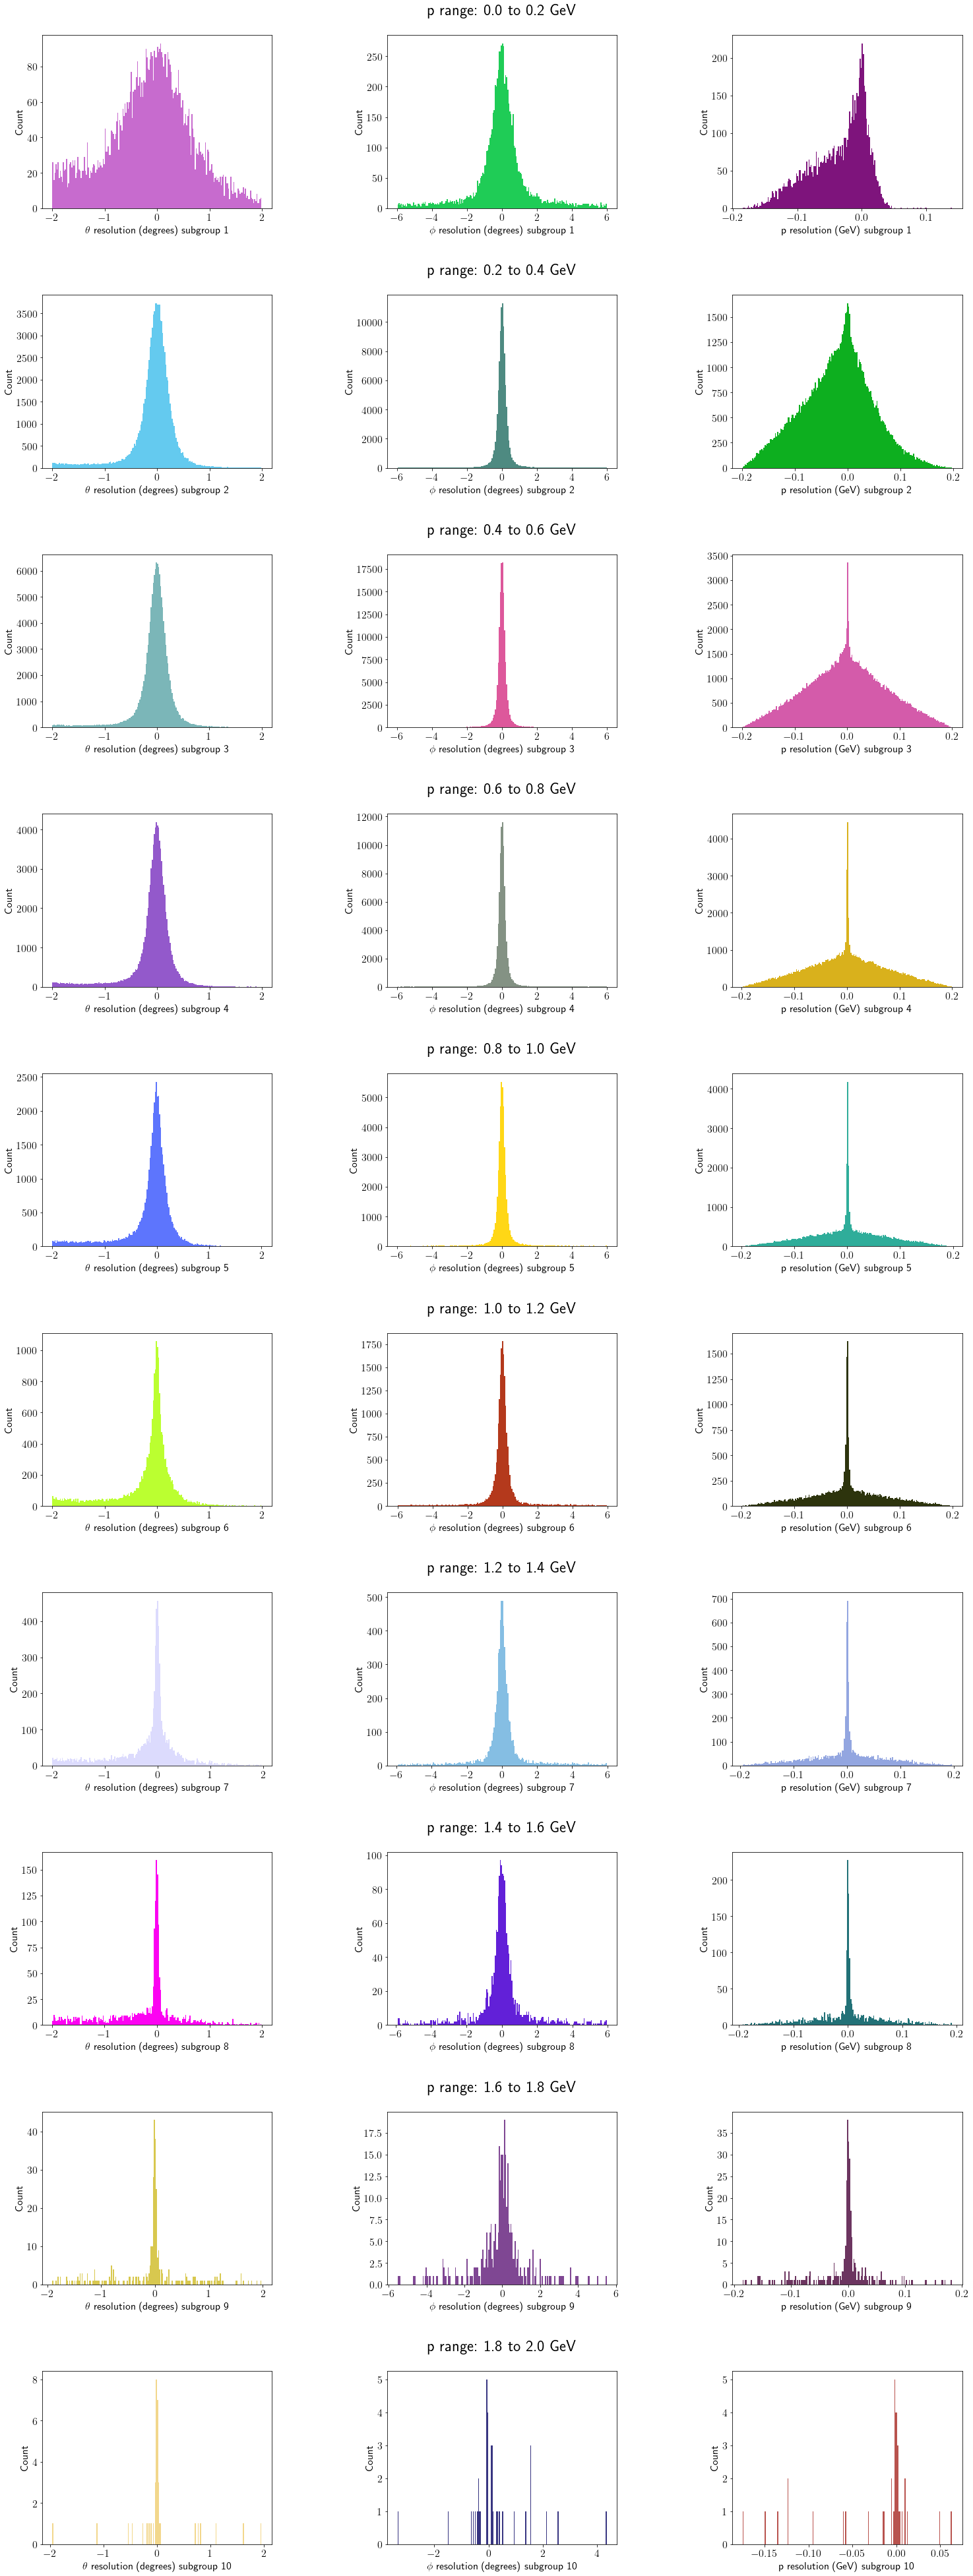

In [14]:
# Create a grid of subplots
fig1, axs1 = plt.subplots(num_sublists, 3, figsize=(25, 70))

# Adjust spacing
fig1.subplots_adjust(hspace=0.5)
fig1.subplots_adjust(wspace=0.5)

p_limits = np.arange(0, max_p + 1 / num_sublists , max_p / num_sublists)

for k in range(num_sublists):
    
    axs1[k, 0].hist(theta_difference_sublists[k], bins=200, color=get_random_color())
    axs1[k, 0].set_ylabel("Count")
    axs1[k, 0].set_xlabel(r"$\theta$ resolution (degrees) subgroup {}".format(k + 1))

    axs1[k, 1].hist(phi_difference_sublists[k], bins=200, color=get_random_color())
    axs1[k, 1].set_ylabel("Count")
    axs1[k, 1].set_xlabel(r"$\phi$ resolution (degrees) subgroup {}".format(k + 1))
    axs1[k, 1].set_title("p range: {:.1f} to {:.1f} GeV\n".format(p_limits[k], p_limits[k+1]), loc='center', fontsize=24)

    axs1[k, 2].hist(p_difference_sublists[k], bins=200, color=get_random_color())
    axs1[k, 2].set_ylabel("Count")
    axs1[k, 2].set_xlabel(r"p resolution (GeV) subgroup {}".format(k + 1))

plt.show()

In [15]:
plt.rcParams['font.size'] = 24

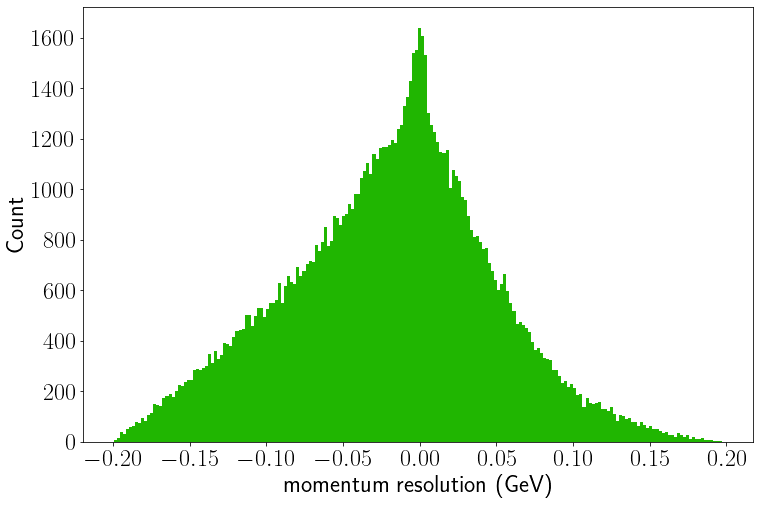

In [16]:
plt.figure(figsize=(12, 8))
plt.hist(p_difference_sublists[1], bins=200, color=get_random_color())
plt.ylabel("Count")
plt.xlabel("momentum resolution (GeV)")
plt.show()

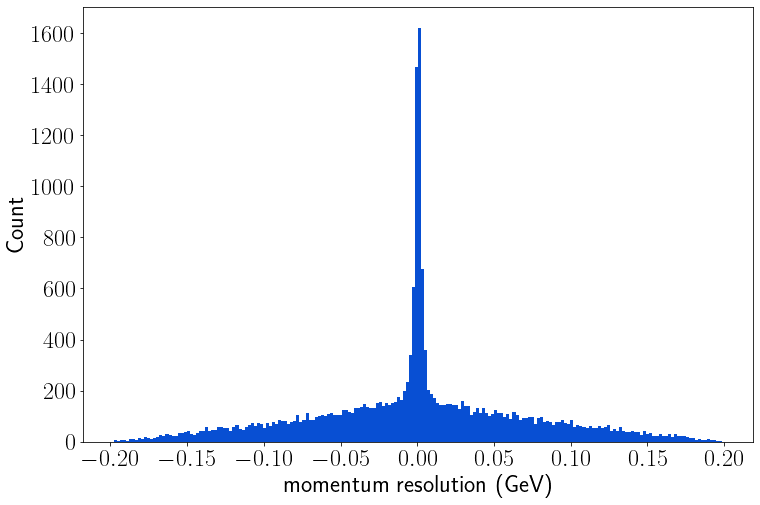

In [18]:
plt.figure(figsize=(12, 8))
plt.hist(p_difference_sublists[5], bins=200, color=get_random_color())
plt.ylabel("Count")
plt.xlabel("momentum resolution (GeV)")
plt.show()